In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import norm, lognorm, anderson, kstest
from sklearn import metrics
from rf_functions import data_setup, run_rf_reg, run_rf_cla, confusion_heatmap
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None

# Regression - single date

In [ ]:
s1_fp = 'input_data/s1_zonal_data.csv'
stats_fp = 'output/stats/scale_shape_both_dates.csv'
moran_fp = 'input_data/moran_max.csv'
output_dir_predict = 'output/rf_predictions/single_date/'
output_dir_metrics = 'output/rf_metrics/single_date/'
out_file_prefix = 'func_test_dB'

targets, predictors = data_setup(s1_fp, stats_fp, moran_fp, s1_units='dB', date=None) # regression
cols_0218 = [c for c in targets.columns if '0219' in c]
cols_0302 = [c for c in targets.columns if '0304' in c]
cols_misc = [c for c in targets.columns if c not in cols_0218 and c not in cols_0302]
cols_misc.remove('Point_ID')
cols_misc.remove('moran_p')
cols_0218 += cols_misc
cols_0302 += cols_misc

cols_0218 = [c for c in cols_0218 if '10m' in c]
cols_0302 = [c for c in cols_0302 if '10m' in c]

targets_0218 = targets[cols_0218].dropna()
targets_0302 = targets[cols_0302].dropna()

# run_rf_reg(targets_0218, predictors.loc[targets_0218.index], n_runs=100, 
#        rf_type='single_target', output_dir_predict=output_dir_predict,
#        output_dir_metrics=output_dir_metrics, out_file_prefix=out_file_prefix)
# run_rf_reg(targets_0302, predictors.loc[targets_0302.index], n_runs=100, 
#        rf_type='single_target', output_dir_predict=output_dir_predict,
#        output_dir_metrics=output_dir_metrics, out_file_prefix=out_file_prefix)



# Regression - multi date

Note - need to run the previous cell to load in the data

In [ ]:
output_dir_predict = 'output/rf_predictions/multi_date/'
output_dir_metrics = 'output/rf_metrics/multi_date/'
out_file_prefix = 'func_test_dB'

def remove_date(col):
    if '0219' in col:
        date_start = col.index('0219')
    elif '0304' in col:
        date_start = col.index('0304')
    else:
        return col
    
    new_col = col[:date_start] + col[date_start+5:]
    if '_1_' in new_col:
        ind = new_col.index('_1_')
        new_col = new_col[:ind] + new_col[ind+2:]
    return new_col

cols_0218_new = [remove_date(c) for c in cols_0218]
cols_0302_new = [remove_date(c) for c in cols_0302]

targets_0218.columns = cols_0218_new
targets_0302.columns = cols_0302_new

targets_all = pd.concat([targets_0218, targets_0302])

# run_rf_reg(targets_all, predictors, n_runs=100, rf_type='single_target', 
#        output_dir_predict=output_dir_predict, output_dir_metrics=output_dir_metrics, 
#        out_file_prefix=out_file_prefix)



# Classification

In [2]:
s1_fp = 'input_data/s1_classification_data.csv' # classification
output_dir_predict = 'output/rf_classification/visually_based/class_results/single_date/'
output_dir_cm = 'output/figures/confusion/'
out_file_prefix = 'smooth_rough_mixed'

targets, predictors = data_setup(s1_fp, s1_units='dB', date=None, 
                                 drop_vv_glcm=False, drop_ad=False)
targets.rename(columns={'class_assignment':'class'}, inplace=True)

# For now, drop 'NC' class
targets = targets.loc[targets['class']!='NC']
targets = targets.loc[targets['class']!='mixed']
targets = targets.loc[targets['class']!='water']

# Dumb indexing to maintain multiindex values to pass to func below
targets_0218 = targets.loc[[i for i in targets.index if i[0] == '0218']]
targets_0302 = targets.loc[[i for i in targets.index if i[0] == '0302']]

# Resample datasets for even samples in all classes
n_samples = 80
targets_0218_rough = targets_0218[targets_0218['class'] == 'rough'].sample(n_samples)
targets_0218_smooth = targets_0218[targets_0218['class'] == 'smooth'].sample(n_samples)
try:
    targets_0218_mixed = targets_0218[targets_0218['class'] == 'mixed'].sample(n_samples)
    targets_0218 = pd.concat([targets_0218_rough, targets_0218_smooth, targets_0218_mixed])
except:
    targets_0218 = pd.concat([targets_0218_rough, targets_0218_smooth])

targets_0302_rough = targets_0302[targets_0302['class'] == 'rough'].sample(n_samples)
targets_0302_smooth = targets_0302[targets_0302['class'] == 'smooth'].sample(n_samples)
try:
    targets_0302_mixed = targets_0302[targets_0302['class'] == 'mixed'].sample(n_samples)
    targets_0302 = pd.concat([targets_0302_rough, targets_0302_smooth, targets_0302_mixed])
except:
    targets_0302 = pd.concat([targets_0302_rough, targets_0302_smooth])

targets = pd.concat([targets_0218, targets_0302])
targets.to_csv('output/stats/classification_samples.csv')

rf_params = {'n_estimators':500,
             'max_features':'sqrt',
             'max_depth':None, 
             'random_state':5033}

dfdf
cm_0218, cm_labels_0218 = run_rf_cla(targets_0218, predictors.loc[targets_0218.index], n_runs=100,
    class_split_method='custom', rf_params=rf_params,
    output_dir_predict=output_dir_predict, out_file_prefix=out_file_prefix,
    output_dir_cm=output_dir_cm, return_cm=True)
cm_0302, cm_labels_0302 = run_rf_cla(targets_0302, predictors.loc[targets_0302.index], n_runs=100, 
    class_split_method='custom', rf_params=rf_params,
    output_dir_predict=output_dir_predict, out_file_prefix=out_file_prefix,
    output_dir_cm=output_dir_cm, return_cm=True)

output_dir_predict = 'output/rf_classification/visually_based/class_results/multi_date/'
output_dir_cm = 'output/figures/confusion/'
out_file_prefix = 'smooth_rough_only'

cm, cm_labels = run_rf_cla(targets, predictors.loc[targets.index], n_runs=100, class_split_method='custom',
    output_dir_predict=output_dir_predict, out_file_prefix=out_file_prefix, rf_params=rf_params,
    output_dir_cm=output_dir_cm, return_cm=True)
    

NameError: name 'dfdf' is not defined

Text(0.5, 0.98, 'Classification accuracy')

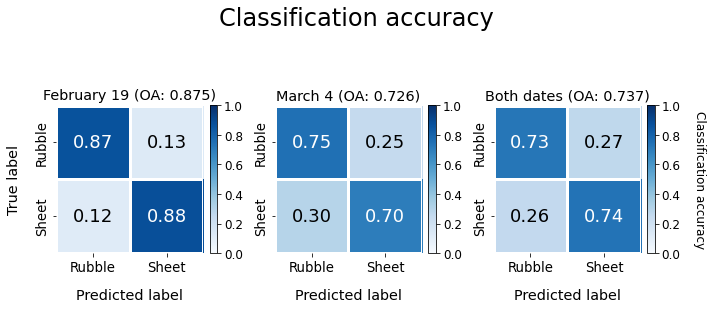

In [9]:
cm_0218 = np.array([[2106, 318],[283, 2093]])
cm_0302 = np.array([[1838, 604],[712, 1646]])
cm = np.array([[3506, 1307],[1222, 3565]])


fig, ax = plt.subplots(1, 3, figsize=(10,5))
cm_labels = ['Rubble','Sheet']
confusion_heatmap(cm=cm_0218, ax=ax[0], cmap='Blues', vmin=0, vmax=cm.max(),
    norm=True, xticklabels=cm_labels, yticklabels=cm_labels, font_scale=1.2,
    cbar_label='', fig_title=f'February 19 (OA: 0.875)', 
    output_dir_cm=output_dir_cm)
confusion_heatmap(cm=cm_0302, ax=ax[1], cmap='Blues', vmin=0, vmax=cm.max(),
    norm=True, xticklabels=cm_labels, yticklabels=cm_labels, font_scale=1.2,
    cbar_label='', fig_title='March 4 (OA: 0.726)', ylabel=False,
    output_dir_cm=output_dir_cm)
confusion_heatmap(cm=cm, ax=ax[2], cmap='Blues', vmin=0, vmax=cm.max(),
    norm=True, xticklabels=['Rubble','Sheet'], yticklabels=cm_labels, font_scale=1.2,
    cbar_label='Classification accuracy', fig_title='Both dates (OA: 0.737)', ylabel=False,
    output_dir_cm=output_dir_cm)
plt.tight_layout()

# fig.savefig('output/figures/confusion/class_results.pdf', dpi=600)




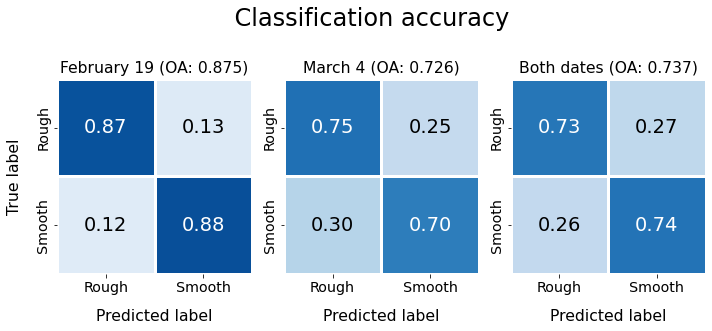

In [21]:
cm_0218 = np.array([[2106, 318],[283, 2093]])
cm_0302 = np.array([[1838, 604],[712, 1646]])
cm = np.array([[3506, 1307],[1222, 3565]])


fig, ax = plt.subplots(1, 3, figsize=(10,5))
cm_labels = ['Rough','Smooth']
confusion_heatmap(cm=cm_0218, ax=ax[0], cmap='Blues', vmin=0, vmax=cm.max(),
    norm=True, xticklabels=cm_labels, yticklabels=cm_labels, font_scale=1.3,
    cbar_label=None, fig_title=f'February 19 (OA: 0.875)', 
    output_dir_cm=output_dir_cm)
confusion_heatmap(cm=cm_0302, ax=ax[1], cmap='Blues', vmin=0, vmax=cm.max(),
    norm=True, xticklabels=cm_labels, yticklabels=cm_labels, font_scale=1.3,
    cbar_label=None, fig_title='March 4 (OA: 0.726)', ylabel=False,
    output_dir_cm=output_dir_cm)
confusion_heatmap(cm=cm, ax=ax[2], cmap='Blues', vmin=0, vmax=cm.max(),
    norm=True, xticklabels=cm_labels, yticklabels=cm_labels, font_scale=1.3,
    cbar_label=None, fig_title='Both dates (OA: 0.737)', ylabel=False,
    output_dir_cm=output_dir_cm)
plt.tight_layout()

fig.suptitle('    Classification accuracy', fontsize=24, y=0.97)
fig.savefig('output/figures/confusion/class_results_poster_colorbar.png', dpi=600, transparent=True)

# Classification - multi date

Note - need to run the previous cell to load in the data

In [15]:
print(cm_0218) 
print(cm_0302)
print(cm)

[[2106  318]
 [ 283 2093]]
[[1838  604]
 [ 712 1646]]
[[3506 1307]
 [1222 3565]]


In [18]:
'' == None

False